## This notebook creates a table with all the outputs from prospector and the calculates SFR
 date: 21-nov-2022

In [1]:
dire = '/Users/brian/Library/CloudStorage/OneDrive-UniversityofHertfordshire/DwarfAGN/dwarf_agn/emcee3/' # my data
# dire = '/Users/brian/Documents/Hertfordshire/dwarf_agn/emcee/' # Ryan's data


The first step is to read in the results into a pandas dataframe, the same can be achieved using the pickle results saved as npy, check these later and compare?

## Getting the Star Formation Rate:
Obtaining the star formation rate requires an estimate of the tage, tau and mass, The star formation rate is the area under the curve of tage and tau, within the mass range of the galaxy in question. For our case we estimate the star formation rate of one of the galaxies in our result.


In [2]:
from dateutil.parser import parse

def is_date(string, fuzzy=False):
    """
    Return whether the string can be interpreted as a date.

    :param string: str, string to check for date
    :param fuzzy: bool, ignore unknown tokens in string if True
    """
    try: 
        string = string.replace("_", "-")
        # print(string)
        parse(string, fuzzy=fuzzy)
        return True

    except ValueError:
        return False


In [3]:
filename = 'gal-51538-emcee-mcmc.h5'
len(filename)

23

In [4]:
import os
import numpy as np
FittedGalaxies = []
for file in os.listdir(dire):
    filename = os.fsdecode(file) 
    if len(filename)>23:
        f  = [int(s) for s in filename.split('_') if s.isdigit()]
        FittedGalaxies.append(f[0])
    # print(f)
arr = np.asarray(FittedGalaxies)

In [5]:
len(arr)

666

In [6]:
import prospect.io.read_results as reader
import numpy as np
from scipy.special import gamma, gammainc
from prospect.plotting.corner import quantile
    
results_type = "emcee"
import os

directory = os.fsencode(dire)
import pandas as pd
columns = ['mass', 'dust', 'tage', 'tau', 'fagn', 'agn_tau', 'duste_umin', 'duste_qpah', 'duste_gamma','mass16', 'dust16', 'tage16', 'tau16', 'fagn16', 'agn_tau16', 'duste_umin16', 'duste_qpah16', 'duste_gamma16', 'psi', 'psi1']
a = []


for file in os.listdir(directory):
    filename = os.fsdecode(file)
    f  = [int(s) for s in filename.split('_') if s.isdigit()]
    if filename.endswith(".h5") and len(filename)<=23 and f[0] in arr: 
        try:
            result, obs, model  = reader.results_from(os.path.join(dire, filename), dangerous=False)

            # Maximum posterior probability sample
            imax = np.argmax(result['lnprobability'])
            csz = result["chain"].shape
            # if result["chain"].ndim > 2:
            # emcee
            i, j = np.unravel_index(imax, result['lnprobability'].shape)
            theta_max = result['chain'][i, j, :].copy()
            flatchain = result["chain"].reshape(csz[0] * csz[1], csz[2])
            #         else:
            #     # dynesty
            # theta_max = result['chain'][imax, :].copy()
            # flatchain = result["chain"]

            # 16th, 50th, and 84th percentiles of the posterior

            weights = result.get("weights", None)

            post_pcts = np.median(flatchain.T,axis=1)
            post_pcts16 = quantile(flatchain.T, q=[0.16, 0.50, 0.84], weights=weights)

            #----------------------------------------------------------------------------------------
            mass, dust, tage, tau, fagn, agn_tau, duste_umin, duste_qpah, duste_gamma = post_pcts[0],post_pcts[1],post_pcts[2],post_pcts[3],post_pcts[4],post_pcts[5],post_pcts[6],post_pcts[7],post_pcts[8]
            mass16, dust16, tage16, tau16, fagn16, agn_tau16, duste_umin16, duste_qpah16, duste_gamma16 = post_pcts16[0,0],post_pcts16[1,0],post_pcts16[2,0],post_pcts16[3,0],post_pcts16[4,0],post_pcts16[5,0],post_pcts16[6,0],post_pcts16[7,0],post_pcts16[8,0]
            #----------------------------------------------------------------------------------------
            #We calculate the star formation rate:

            tage, tau, mass = post_pcts[2], post_pcts[3], post_pcts[0]
            # for delay tau this function gives the (unnormalized) SFR 
            # for any t, tau combo in M_sun/Gyr
            # sfr = lambda t,tau: return (t/tau) * np.exp(-t/tau)

            sfr = lambda t,tau:(t/tau) * np.exp(-t/tau)
            # now we numerically integrate this SFH from 0 to tage to get the mass formed
            times = np.linspace(0, tage, 1000)
            A = np.trapz(sfr(times, tau), times)
            # But this could also be done using an incomplete gamma function (integral of xe^{-x})
            A = tau * gamma(2) * gammainc(2, tage/tau)
            # and now we renormalize the formed mass to the actual mass value 
            # to get the the SFR in M_sun per Gyr 
            psi = mass * sfr(tage, tau) / A
            # if we want SFR in Msun/year
            psi1 = psi/1e9

            row = mass, dust, tage, tau, fagn, agn_tau, duste_umin, duste_qpah, duste_gamma,mass16, dust16, tage16, tau16, fagn16, agn_tau16, duste_umin16, duste_qpah16, duste_gamma16, psi, psi1,
            a.append(row)
        except:
            print(filename)
            
    
df = pd.DataFrame(a,columns=columns)



In [7]:
_

666

In [8]:
df

,mass,dust,tage,tau,fagn,agn_tau,duste_umin,duste_qpah,duste_gamma,mass16,dust16,tage16,tau16,fagn16,agn_tau16,duste_umin16,duste_qpah16,duste_gamma16,psi,psi1


In [9]:
rand_pick = np.arange(11000)
rand_pick

array([    0,     1,     2, ..., 10997, 10998, 10999])

In [10]:
rand_pick = np.random.choice(range(len(df['mass'])not in a) , 1000)
rand_pick

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [12]:
FittedGalaxies = []
for file in os.listdir(directory):
    try:
        filename = os.fsdecode(file)
        f  = [int(s) for s in filename.split('_') if s.isdigit()]
        FittedGalaxies.append(f[0])
    except:
        filename = os.fsdecode(file)
a = np.asarray(FittedGalaxies)

In [13]:
a = np.asarray(FittedGalaxies)

In [14]:
a.tofile('fitted.dat')
c = np.fromfile('fitted.dat', dtype=int)
c == a

array([ True,  True,  True, ...,  True,  True,  True])

In [15]:
c

array([1669, 1739, 1571, ..., 2699, 2581, 2817])

In [16]:
txt = "h3110_23 cat 444.4 rabbit 11 2 dog"
[float(s) for s in txt.split('_') if s.isdigit()]

[]

In [17]:
s="Planning_Group_20180108.ind"
txt.split('_')

['h3110', '23 cat 444.4 rabbit 11 2 dog']

In [18]:
obs

NameError: name 'obs' is not defined

In [19]:
# df = pd.DataFrame(a,columns=columns)

In [20]:
def f(row):
    if row['fagn']>0.01:
        val = 'agn'
    else:
        val = 'no_agn'
    return val

In [21]:
df['perc_agn'] = df.apply(f, axis=1)

ValueError: Wrong number of items passed 20, placement implies 1

In [22]:
df_agn =df[df.fagn>0.01]

In [23]:
bins = np.arange(7.0, 10.5, 0.5)

In [24]:
# bins = np.arange(np.log10(df['mass']).min(), np.log10(df['mass']).max(), 0.3) # adjust as desired

In [25]:
df

,mass,dust,tage,tau,fagn,agn_tau,duste_umin,duste_qpah,duste_gamma,mass16,dust16,tage16,tau16,fagn16,agn_tau16,duste_umin16,duste_qpah16,duste_gamma16,psi,psi1


In [26]:
# plt.plot(np.log10(df['mean_mass']),np.log10(df['mean_fagn'] ),'o')

In [27]:
# bins = np.arange(np.log10(df['mass']).min(), np.log10(df['mass']).max(), 0.5) # adjust as desired
df['new_group'] = df.groupby(pd.cut(np.log10(df['mass']), bins, right=False))['fagn'].grouper.group_info[0] + 1

In [28]:
df['logmass'] = np.log10(df.mass)

In [29]:
# I defind the agn sample
df_agn =df[df.fagn>0.01]

# bins = np.arange(np.log10(df_agn['mass']).min(), np.log10(df_agn['mass']).max(), 0.5) # adjust as desired

df_stats2 = pd.DataFrame() # DataFrame for the results
df_stats2['mean_fagn']  = df_agn.groupby(pd.cut(np.log10(df_agn['mass']), bins, right=False)).median()['fagn']
df_stats2['mean_fagn16']  = df_agn.groupby(pd.cut(np.log10(df_agn['mass']), bins, right=False)).median()['fagn16']
df_stats2['mean_mass']  = df_agn.groupby(pd.cut(np.log10(df_agn['mass']), bins, right=False)).median()['mass']
df_stats2['st_dev'] = df_agn.groupby(pd.cut(np.log10(df_agn['mass']), bins, right=False)).std()['fagn']

KeyError: 'fagn'

KeyError: 'mean_mass'

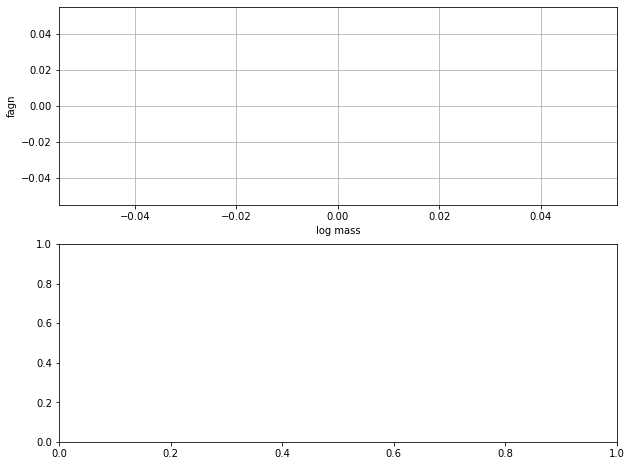

In [30]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize = (10,8))
axs[0].plot(np.log10(df.mass),np.log10(df.fagn),'.',color='grey')
axs[0].plot(np.log10(df_agn.mass),np.log10(df_agn.fagn),'.',color='black')
axs[0].set_xlabel('log mass')
axs[0].set_ylabel('fagn')
axs[0].grid(True)


axs[1].plot(np.log10(df_stats2['mean_mass']),df_stats2['mean_fagn'],'o-')
axs[1].plot(np.log10(df_stats2['mean_mass']),df_stats2['mean_fagn16'],'o-')
axs[1].set_xlabel('log mass')
axs[1].set_ylabel('fagn median')
axs[1].grid(True)

plt.legend()
fig.tight_layout()
plt.show()
# plt.plot(df_agn.mass1,df_agn.fagn,'o')

In [ ]:
# bins = np.arange(np.log10(df['mass']).min(), np.log10(df['mass']).max(), 0.2) # adjust as desired

df_stats = pd.DataFrame() # DataFrame for the results
df_stats['mean_mass']  = df.groupby(pd.cut(np.log10(df['mass']), bins, right=False)).median()['mass']
df_stats['log_mean_mass'] = np.log10(df_stats['mean_mass'])
df_stats['agn_mean_sfr']  = df[df['fagn'] > 0.01].groupby(pd.cut(np.log10(df[df['fagn'] > 0.01]['mass']), bins, right=False)).median()['psi1']
df_stats['mean_sfr']    =  df.groupby(pd.cut(np.log10(df['mass']), bins, right=False)).median()['psi1']


In [ ]:
df_stats

In [ ]:
df_stats1 = pd.DataFrame()
df = df.sort_values(by=['mass'])
df_stats1['med_mass'] = df.groupby('new_group')['logmass'].median()
df_stats1['agn_count'] = df[df['fagn'] > 0.01].groupby('new_group')['fagn'].count()
df_stats1['agn_count16'] = df[df['fagn16'] > 0.01].groupby('new_group')['fagn16'].count()
df_stats1['tot_count'] =df.groupby('new_group')['fagn'].count()
df_stats1['tot_count16'] =df.groupby('new_group')['fagn16'].count()
df_stats1['percentage'] = round(df_stats1['agn_count']/df_stats1['tot_count'] * 100)
df_stats1['percentage16'] = round(df_stats1['agn_count16']/df_stats1['tot_count16'] * 100)

df_stats1 = df_stats1.sort_values(by=['med_mass'])

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Edit the font, font size, and axes width
mpl.rcParams['font.family'] = 'Avenir'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2




fig, axs = plt.subplots(3, 1, figsize = (10,12))
# axs[0].plot(np.log10(df['mass']),np.log10(df['psi1']),'.')
axs[0].plot(df_stats['log_mean_mass'],np.log10(df_stats['agn_mean_sfr']),'o-',label = 'agn')
axs[0].plot(df_stats['log_mean_mass'],np.log10(df_stats['mean_sfr']),'o-',label = 'all')
# axs[1].set_xlabel('mass')
axs[0].set_ylabel('log median sfr')
axs[0].legend(loc=2,fontsize=12)
axs[0].grid(True)


axs[1].plot(df_stats1['med_mass'],df_stats1['agn_count'],'o-',label = 'agn')
axs[1].plot(df_stats1['med_mass'],df_stats1['tot_count'],'o-',label = 'all')
# axs[0].set_xlabel('mass')
axs[1].set_ylabel('count')
axs[1].grid(True)
axs[1].legend(loc=2,fontsize=12)


axs[2].plot(df_stats1['med_mass'],df_stats1['percentage'],'o-',label = 'median')
axs[2].plot(df_stats1['med_mass'],df_stats1['percentage16'],'o-',label = '16th percentile')
axs[2].set_xlabel('mass')
axs[2].set_ylabel('agn percentage')
axs[2].grid(True)

plt.legend()
fig.tight_layout()
plt.savefig('second_run.png')
plt.show()

In [ ]:
(df[df['fagn'] > 0.01].groupby('new_group')['fagn'].count()/df.groupby('new_group')['fagn'].count()*100).mean()

In [ ]:
df[df['fagn'] > 0.01].groupby('new_group')['fagn'].count()

In [ ]:
# plt.plot(df.groupby('new_group')['logmass'].median(),df[df['fagn'] > 0.01].groupby('new_group')['fagn'].count()/df.groupby('new_group')['fagn'].count(),'o-')

In [ ]:
import prospect.io.read_results as reader
import numpy as np
from scipy.special import gamma, gammainc
from prospect.plotting.corner import quantile
    
results_type = "emcee"
import os

directory = os.fsencode(dire)
import pandas as pd
columns = ['mass', 'dust', 'tage', 'tau', 'fagn', 'agn_tau', 'duste_umin', 'duste_qpah', 'duste_gamma', 'psi', 'psi1']
a = []

ii=0
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    
    if filename.endswith(".h5"): 
        if ii<10:
            result, obs, _  = reader.results_from(os.path.join(dire, filename), dangerous=False)

            # Maximum posterior probability sample
            imax = np.argmax(result['lnprobability'])
            csz = result["chain"].shape
            # if result["chain"].ndim > 2:
            # emcee
            i, j = np.unravel_index(imax, result['lnprobability'].shape)
            theta_max = result['chain'][i, j, :].copy()
            flatchain = result["chain"].reshape(csz[0] * csz[1], csz[2])
            #         else:
            #     # dynesty
            # theta_max = result['chain'][imax, :].copy()
            # flatchain = result["chain"]

            # 16th, 50th, and 84th percentiles of the posterior

            weights = result.get("weights", None)
            post_pcts = quantile(flatchain.T, q=[0.16, 0.50, 0.84], weights=weights)
            #----------------------------------------------------------------------------------------
            mass, dust, tage, tau, fagn, agn_tau, duste_umin, duste_qpah, duste_gamma = post_pcts[0,1],post_pcts[1,1],post_pcts[2,1],post_pcts[3,1],post_pcts[4,1],post_pcts[5,1],post_pcts[6,1],post_pcts[7,1],post_pcts[8,1]

            #----------------------------------------------------------------------------------------
            #We calculate the star formation rate using

            tage, tau, mass = post_pcts[2,1], post_pcts[3,1], post_pcts[0,1]
            # for delay tau this function gives the (unnormalized) SFR 
            # for any t, tau combo in M_sun/Gyr
            # sfr = lambda t,tau: return (t/tau) * np.exp(-t/tau)

            sfr = lambda t,tau:(t/tau) * np.exp(-t/tau)
            # now we numerically integrate this SFH from 0 to tage to get the mass formed
            
            # times = np.linspace(0, tage, 1000)
            # A = np.trapz(sfr(times, tau), times)
            
            # But this could also be done using an incomplete gamma function (integral of xe^{-x})
            A = tau * gamma(2) * gammainc(2, tage/tau)
            # and now we renormalize the formed mass to the actual mass value 
            # to get the the SFR in M_sun per Gyr 
            psi = mass * sfr(tage, tau) / A
            # if we want SFR in Msun/year
            psi1 = psi/1e9
            print(filename)
            row = mass, dust, tage, tau, fagn, agn_tau, duste_umin, duste_qpah, duste_gamma, psi, psi1
            a.append(row)
            cfig = reader.subcorner(result)
    ii = ii+1
        




In [ ]:
df

In [ ]:
bins = np.arange(-0.00000000000001,9, 5) # adjust as desired
df['mean'] = df.groupby(pd.cut(df['mass'], bins, right=False)).mean()['mass']
df['st_dev'] = df.groupby(pd.cut(df['mass'], bins, right=False)).std()['mass']


In [ ]:
df

In [ ]:
tage, tau, mass = post_pcts[2,1], post_pcts[3,1], post_pcts[0,1]
# for delay tau this function gives the (unnormalized) SFR 
# for any t, tau combo in M_sun/Gyr
# sfr = lambda t,tau: return (t/tau) * np.exp(-t/tau)

sfr = lambda t,tau:(t/tau) * np.exp(-t/tau)
# now we numerically integrate this SFH from 0 to tage to get the mass formed

# times = np.linspace(0, tage, 1000)
# A = np.trapz(sfr(times, tau), times)

# But this could also be done using an incomplete gamma function (integral of xe^{-x})
A = tau * gamma(2) * gammainc(2, tage/tau)
# and now we renormalize the formed mass to the actual mass value 
# to get the the SFR in M_sun per Gyr 
psi = mass * sfr(tage, tau) / A
# if we want SFR in Msun/year
psi1 = psi/1e9

In [ ]:
out_obs = obs
out = result

In [ ]:
out

In [ ]:
import matplotlib.pyplot as pl
sfig, saxes = pl.subplots(2, 1, gridspec_kw=dict(height_ratios=[1, 4]), sharex=True)
ax = saxes[1]
pwave = np.array([f.wave_effective for f in out_obs["filters"]])
# plot the data
ax.plot(pwave, out_obs["maggies"], linestyle="", marker="o", color="k")
ax.errorbar(pwave,  out_obs["maggies"], out_obs["maggies_unc"], linestyle="", color="k", zorder=10)
ax.set_ylabel(r"$f_\nu$ (maggies)")
ax.set_xlabel(r"$\lambda$ (AA)")
ax.set_xlim(3e3, 1e4)
ax.set_ylim(out_obs["maggies"].min() * 0.1, out_obs["maggies"].max() * 5)
ax.set_yscale("log")

# get the best-fit SED
bsed = out["bestfit"]
# ax.plot(bsed["restframe_wavelengths"] * (1+out_obs["redshift"]), bsed["spectrum"], color="firebrick", label="MAP sample")
ax.plot(pwave, bsed["photometry"], linestyle="", marker="s", markersize=10, mec="orange", mew=3, mfc="none")

ax = saxes[0]
chi = (out_obs["maggies"] - bsed["photometry"]) / out_obs["maggies_unc"]
ax.plot(pwave, chi, linestyle="", marker="o", color="k")
ax.axhline(0, color="k", linestyle=":")
ax.set_ylim(-2, 2)
ax.set_ylabel(r"$\chi_{\rm best}$")

In [ ]:
out["bestfit"]